In [1]:
import tensorflow as tf
import keras 
import numpy as np 


In [2]:
import tensorflow.keras.backend as K

In [9]:
class self_attention (keras.layers.Layer) :
    def __init__ (self,return_attention=False,**kwargse) :
        super(self_attention,self).__init__()
        self.return_attention = return_attention 
    
    def build (self,input_shape) :
        self.W_q = self.add_weight(shape=(input_shape[-1],input_shape[-1]),initializer="random_normal",trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1],input_shape[-1]),initializer="random_normal",trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1],input_shape[-1]), initializer="random_normal",trainable=True)
    
    def call (self,inputs) :
        Q = K.dot(inputs, self.W_q) #query
        K_mat = K.dot(inputs,self.W_k) # keys
        V = K.dot(inputs,self.W_v) # values

        attention_scores = K.batch_dot(Q, K.permute_dimensions(K_mat, (0, 2, 1))) / K.sqrt(K.cast(K.shape(K_mat)[-1], dtype="float32"))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        output = K.batch_dot(attention_weights, V)
        if self.return_attention :
            return attention_weights
        return output

In [10]:
class attentionVisualizer (keras.callbacks.Callback) :
    def __init__ (self,model,sample_input) :
        self.model = model 
        self.sample_input = sample_input 
    
    def on_epoch_end(self, epoch, logs=None):
        attention_layer = self.model.get_layer(index=2)  # Ambil Self-Attention
        attention_weights = attention_layer(self.sample_input).numpy()
        
        print(f"\n🔍 Attention Weights (Epoch {epoch+1}):\n", attention_weights)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_weights, tokens):
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights[0], xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=True)
    plt.xlabel("Query")
    plt.ylabel("Key")
    plt.title("Self-Attention Heatmap")
    plt.show()


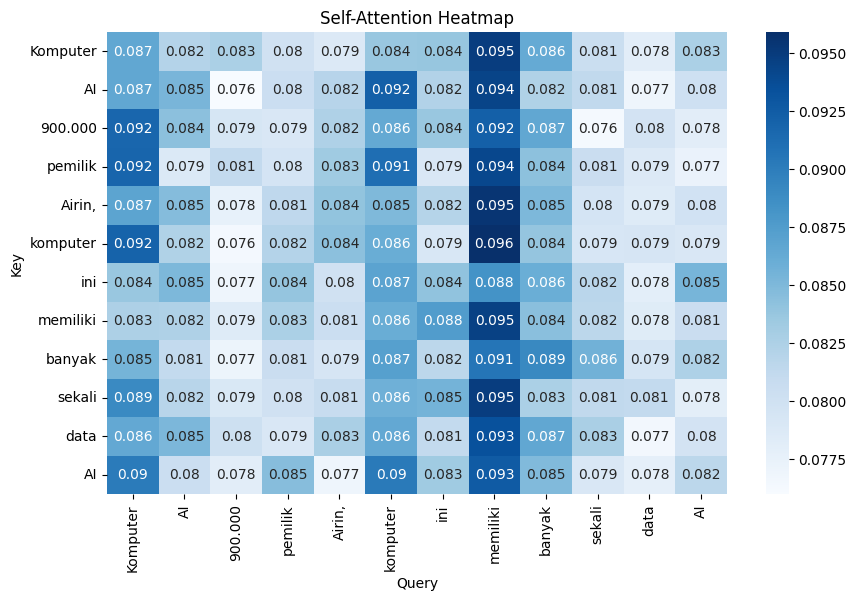

In [13]:
sample_text = ["Komputer AI 900.000 pemilik Airin, komputer ini memiliki banyak sekali data AI"]
tokenized_text = sample_text[0].split()

sample_input = np.random.rand(1, len(tokenized_text), 128)  # Input acak sebagai contoh
attention_weights =self_attention(return_attention=True)(sample_input).numpy()

plot_attention(attention_weights, tokenized_text)


In [14]:
import numpy as np

X = np.array([[1, 0], [0, 1], [1, 1]])  # Representasi sederhana

# Bobot acak
W_q = np.random.rand(2, 2)
W_k = np.random.rand(2, 2)
W_v = np.random.rand(2, 2)

Q = X @ W_q
K = X @ W_k
V = X @ W_v

# Skor perhatian
scores = Q @ K.T
attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)  # Softmax

# Hasil akhir
output = attention_weights @ V

print("Attention Weights:\n", attention_weights)


Attention Weights:
 [[0.2108547  0.33798416 0.45116114]
 [0.16659141 0.35814362 0.47526496]
 [0.09478441 0.32662886 0.57858673]]


In [40]:
# Contoh input (3 kata, dengan dimensi embedding 4)
X = np.array([[1, 0, 1, 0],  # Anima
              [0, 1, 0, 1],  # melihat
              [1, 1, 0, 0]]) # AI

# Inisialisasi bobot random
W_Q = np.random.rand(4, 4)
W_K = np.random.rand(4, 4)
W_V = np.random.rand(4, 4)

In [41]:
# Hitung Query, Key, Value
Q = np.dot(X, W_Q)
K = np.dot(X, W_K)
V = np.dot(X, W_V)

In [42]:
scores = np.dot(Q,K.T) / np.sqrt(4)
attention_weight = np.exp(scores) / np.sum(np.exp(scores),axis=1,keepdims=True)

In [43]:
output = np.dot(attention_weights, V)

print("Attention Weights:\n", attention_weights)
print("Output:\n", output)

Attention Weights:
 [[0.2108547  0.33798416 0.45116114]
 [0.16659141 0.35814362 0.47526496]
 [0.09478441 0.32662886 0.57858673]]
Output:
 [[0.29637193 1.2703136  0.79461674 0.74890128]
 [0.30137154 1.29561897 0.77393591 0.73932255]
 [0.31078612 1.33857679 0.75235604 0.71926186]]


In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

# Contoh dataset (input → target)
input_texts = ["aku suka belajar", "kamu makan nasi", "dia membaca buku"]
target_texts = ["i like learning", "you eat rice", "he reads books"]

# Tokenisasi teks
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts + target_texts)

input_seqs = tokenizer.texts_to_sequences(input_texts)
target_seqs = tokenizer.texts_to_sequences(target_texts)

# Padding sequences
input_seqs = tf.keras.preprocessing.sequence.pad_sequences(input_seqs, padding="post")
target_seqs = tf.keras.preprocessing.sequence.pad_sequences(target_seqs, padding="post")

# Model parameter
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64
lstm_units = 128

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, h, c = self.lstm(x)
        return output, h, c  # Mengembalikan state LSTM

# Self-Attention
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.W_q = Dense(units)
        self.W_k = Dense(units)
        self.W_v = Dense(units)
    
    def call(self, inputs):
        Q = self.W_q(inputs)
        K = self.W_k(inputs)
        V = self.W_v(inputs)
        
        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        
        context_vector = tf.matmul(attention_weights, V)
        return context_vector, attention_weights

# Decoder tanpa teacher forcing
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.attention = SelfAttention(lstm_units)
        self.fc = Dense(vocab_size, activation="softmax")

    def call(self, x, hidden_state):
        x = self.embedding(x)
        context_vector, _ = self.attention(hidden_state)

        # Ubah context_vector agar sesuai dengan dimensi waktu x
        context_vector = tf.expand_dims(context_vector[:, -1, :], 1)  # Ambil vektor terakhir, lalu tambahkan dimensi waktu

        x = tf.concat([context_vector, x], axis=-1)
        output, _, _ = self.lstm(x)
        x = self.fc(output)
        return x

# Inisialisasi model
encoder = Encoder(vocab_size, embedding_dim, lstm_units)
decoder = Decoder(vocab_size, embedding_dim, lstm_units)

# Optimizer dan loss function
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)




In [50]:
# Training loop tanpa teacher forcing
EPOCHS = 100
batch_size = 2

for epoch in range(EPOCHS):
    total_loss = 0
    for i in range(len(input_seqs)):
        with tf.GradientTape() as tape:
            enc_output, enc_h, enc_c = encoder(tf.expand_dims(input_seqs[i], 0))
            dec_input = tf.expand_dims([tokenizer.word_index["i"]], 0)  # Mulai dengan "i"

            loss = 0
            for t in range(target_seqs.shape[1] - 1):
                predictions = decoder(dec_input, enc_output)
                loss += loss_fn(target_seqs[i, t:t+1], predictions[:, 0, :])
                predicted_id = tf.argmax(predictions, axis=-1).numpy()[0, 0]
                dec_input = tf.expand_dims([predicted_id], 0)

            total_loss += loss

        grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

    print(f"Epoch {epoch+1}, Loss: {total_loss.numpy()}")

print("Training selesai!")

Epoch 1, Loss: 17.48244857788086
Epoch 2, Loss: 17.383895874023438
Epoch 3, Loss: 17.225229263305664
Epoch 4, Loss: 16.992286682128906
Epoch 5, Loss: 16.73537826538086
Epoch 6, Loss: 16.51095199584961
Epoch 7, Loss: 16.261301040649414
Epoch 8, Loss: 15.997407913208008
Epoch 9, Loss: 15.794315338134766
Epoch 10, Loss: 15.608567237854004
Epoch 11, Loss: 15.458706855773926
Epoch 12, Loss: 15.23105239868164
Epoch 13, Loss: 14.986417770385742
Epoch 14, Loss: 14.757413864135742
Epoch 15, Loss: 14.57408618927002
Epoch 16, Loss: 14.41627311706543
Epoch 17, Loss: 14.258044242858887
Epoch 18, Loss: 14.092625617980957
Epoch 19, Loss: 13.934364318847656
Epoch 20, Loss: 13.767373085021973
Epoch 21, Loss: 13.608729362487793
Epoch 22, Loss: 13.569100379943848
Epoch 23, Loss: 13.484655380249023
Epoch 24, Loss: 13.416718482971191
Epoch 25, Loss: 13.367186546325684
Epoch 26, Loss: 13.330142974853516
Epoch 27, Loss: 13.301255226135254
Epoch 28, Loss: 13.09228229522705
Epoch 29, Loss: 13.260379791259766
E

In [53]:
models = keras.Model(inputs=encoder,outputs = decoder)

ValueError: All `inputs` values must be KerasTensors. Received: inputs=<Encoder name=encoder_1, built=True> including invalid value <Encoder name=encoder_1, built=True> of type <class '__main__.Encoder'>

In [ ]:
def generate_text(model, input_seq, tokenizer, max_len=20):
    result = []
    hidden_state = model.encoder(input_seq)  # Dapatkan state awal dari encoder
    
    dec_input = tf.constant([[tokenizer.word_index["<start>"]]])  # Token pertama
    
    for _ in range(max_len):
        predictions, hidden_state = model.decoder(dec_input, hidden_state)
        predicted_id = tf.argmax(predictions[0, 0]).numpy()  # Ambil token dengan probabilitas tertinggi

        if predicted_id == tokenizer.word_index["<end>"]:
            break  # Hentikan jika model memprediksi token akhir

        result.append(tokenizer.index_word[predicted_id])  # Tambahkan ke hasil
        dec_input = tf.constant([[predicted_id]])  # Masukkan kembali sebagai input decoder
    
    return " ".join(result)

# Contoh penggunaan:
test_sentence = "Komputer AI dapat mengenali teks"
test_seq = tokenizer.texts_to_sequences([test_sentence])
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=3, padding='post')

generated_text = generate_text(model, test_seq, tokenizer)
print("Prediksi Model:", generated_text)


NameError: name 'max_len' is not defined

In [3]:
class SelfAttention (keras.layers.Layer) :
    def __init__ (self,d_model) :
        super(SelfAttention,self).__init__()
        self.d_model = d_model 
        self.W_q = keras.layers.Dense(d_model)
        self.W_k = keras.layers.Dense(d_model)
        self.W_v = keras.layers.Dense(d_model)
    
    def call (self,x) :
        Q = self.W_q(x)
        K_at = self.W_k(x)
        V = self.W_v(x)
        d_k = tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        attention_scores = tf.nn.softmax(tf.matmul(Q,tf.transpose(K_at,perm=[0,2,1])) / d_k,axis=1)
        output = tf.matmul(attention_scores, V)
        return output 

In [4]:
class TransformersEncoder (keras.layers.Layer) :
    def __init__ (self,d_model) :
        super(TransformersEncoder,self).__init__()
        self.Attention = SelfAttention(d_model)
        self.norm1 = keras.layers.LayerNormalization()
        self.ffn = keras.layers.Dense(d_model,activation='relu')
        self.norm2 = keras.layers.LayerNormalization()
    
    def call (self,x) :
        attention = self.Attention(x)
        x = self.norm1(x + attention)
        ffn_output = self.ffn(x)
        x = self.norm2 (x + ffn_output)
        return x 

In [5]:
class TransformersDecoder (keras.layers.Layer) :
    def __init__ (self,d_model) :
        super(TransformersDecoder,self).__init__()
        self.Attention = SelfAttention(d_model)
        self.norm1 = keras.layers.LayerNormalization()
        self.Encoder_to_Decoder = SelfAttention(d_model)
        self.norm2 = keras.layers.LayerNormalization()
        self.ffn = keras.layers.Dense(d_model,activation='relu')
        self.norm3 = keras.layers.LayerNormalization()
    
    def call (self,x,encouder_output) :
        attn_output = self.Attention(x)
        x = self.norm1(x + attn_output)
        attn_output = self.Encoder_to_Decoder(x)
        x= self.norm2 (x+attn_output)
        ffn_output = self.ffn(x)
        x = self.norm3 (x+ffn_output)
        return x 

In [6]:
class Transformers (keras.Model) :
    def __init__ (self,d_model,vocab_size ) :
        super(Transformers,self).__init__()
        self.embedding = keras.layers.Embedding(vocab_size,d_model)
        self.encoder = TransformersEncoder(d_model)
        self.decoder = TransformersDecoder(d_model)
        self.final_Layer = keras.layers.Dense(vocab_size,activation='softmax')
    
    def call (self,encoder_input,decoder_input) :
        enc_ouput = self.encoder(self.embedding(encoder_input))
        dec_output = self.decoder(self.embedding(decoder_input),enc_ouput)
        return self.final_Layer(dec_output)

In [7]:
d_model = 128
vocab_size = 2000

transformer = Transformers(d_model,vocab_size)
encoder_input = np.random.randint(0,vocab_size,(1,5))
decoder_input = np.random.randint(0,vocab_size,(1,5))


In [11]:
encoder_input

array([[ 55,  22, 377, 910,  37]])

In [12]:
decoder_input

array([[ 137, 1542, 1892,  297,  227]])

In [29]:
output = transformer(encoder_input,decoder_input)

In [18]:
output[0][2]

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([0.00041048, 0.00063606, 0.00046013, ..., 0.00037671, 0.00050175,
       0.00039762], dtype=float32)>

In [30]:
list_tru = list() 
for i in range(len(output[0])) :
    list_tru.append(np.argmax(output[0][i]))

In [26]:
np.argmax(output[0][4])

1610

In [31]:
list_tru

[1186, 1814, 1148, 280, 1610]

In [32]:
class Attention_non_Transoformermers (keras.layers.Layer) :
    def __init__ (self,d_k) :
        super(Attention_non_Transoformermers,self).__init__()
        self.d_k = d_k
    
    def build(self,inputs) :
        self.W_q = self.add_weight(shape=(inputs[-1],self.d_k),initializer="random_normal",trainable=True)
        self.W_k = self.add_weight(shape=(inputs[-1],self.d_k),initializer="random_normal",trainable=True)
        self.W_v = self.add_weight(shape=(inputs[-1],self.d_k),initializer="random_normal",trainable=True)

    def call (self,inputs) :
        Q = tf.matmul(inputs,self.W_q)
        K_at = tf.matmul(inputs,self.W_k)
        V = tf.matmul(inputs,self.W_v)
        d_k = tf.math.sqrt(float(self.d_k))
        attention_scores = tf.nn.softmax(tf.matmul(Q,tf.transpose(K_at,perm=[0,2,1])) / d_k,axis=-1)
        output = tf.matmul(attention_scores,V)
        return output

In [60]:
class Text_classifier (keras.Model) :
    def __init__ (self,vocab_size,embbed_size,d_k,num_classes) :
        super (Text_classifier,self).__init__ ()
        self.embedding = keras.layers.Embedding(vocab_size,embbed_size)
        self.global_normal = keras.layers.GlobalAveragePooling1D()
        self.Attention = Attention_non_Transoformermers(d_k)
        self.Dense1 = keras.layers.Dense(128,activation="relu")
        self.fc = keras.layers.Dense(num_classes,activation='softmax')
    
    def call(self,inputs) :
        x = self.embedding(inputs)
        x = self.Attention(x)
        x = self.global_normal(x)
        x = self.Dense1(x)
        return self.fc(x)

In [36]:
vocab_size = 5000
embed_dim = 128
d_k = 64
num_classes = 3  # Contoh untuk klasifikasi 3 kelas

model = Text_classifier(vocab_size=vocab_size, embbed_size=embed_dim, d_k = d_k, num_classes = num_classes)
model.build(input_shape=(None, 50))  # Panjang maksimal teks = 50 token
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'text_classifier_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_non__transoformermer… │ ?                      │   0 (unbuilt) │
│ (Attention_non_Transoformermer… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
def make_random () :
    return [np.random.randint(0,10) for i in range(4)]

In [24]:
X = [make_random() for _ in range(100)]

In [25]:
X = np.array(X)

In [27]:
label = list() 
for i in X :
    if 5 in i :
        label.append(1)
    else :
        label.append(0)

In [ ]:
vocab_size = 10
num_classes = 10
d_k = 32
embed_dim = 32

In [46]:
Models = Text_classifier(vocab_size=vocab_size,embbed_size=embed_dim,d_k = d_k,num_classes=num_classes)

In [47]:
Models.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [48]:
Models.summary()

Model: "text_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_non__transoformermer… │ ?                      │   0 (unbuilt) │
│ (Attention_non_Transoformermer… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
x_train= X
y_train = np.array(label).reshape(-1,1)

In [49]:
Models.fit(x_train,y_train,verbose=1,epochs=10)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 1), output.shape=(None, 4, 3)

In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1️⃣ Membuat teks acak (dummy dataset)
vocab_words = ["apple", "banana", "orange", "cat", "dog", "fish", "happy", "sad", "angry", "run", "walk", "sleep"]
num_samples = 1000  # Jumlah sampel
max_len = 10  # Panjang maksimal teks

# Buat teks acak dengan memilih kata secara random
np.random.seed(42)
texts = [" ".join(np.random.choice(vocab_words, max_len)) for _ in range(num_samples)]

# 2️⃣ Membuat label acak untuk klasifikasi 3 kelas (0, 1, 2)
labels = np.random.randint(0, 3, size=(num_samples,))

# 3️⃣ Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# 4️⃣ Membuat dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((padded_sequences, labels))
dataset = dataset.shuffle(1000).batch(32)  # Batch size 32

# 5️⃣ Membagi dataset menjadi train dan test
train_size = int(0.8 * num_samples)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print("Contoh teks acak:", texts[0])
print("Contoh label:", labels[0])
print("Contoh token hasil tokenisasi:", sequences[0])


Contoh teks acak: happy cat walk sad dog happy run orange happy walk
Contoh label: 2
Contoh token hasil tokenisasi: [5, 12, 13, 10, 9, 5, 4, 7, 5, 13]


In [41]:
# Compile & Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=100, validation_data=test_dataset)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4275 - loss: 1.0592
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4379 - loss: 1.0531
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4102 - loss: 1.0691
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4386 - loss: 1.0605
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4505 - loss: 1.0524
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4674 - loss: 1.0435
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4330 - loss: 1.0652
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4446 - loss: 1.0645
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4502 - loss: 1.0643
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4332 - loss: 1.0632
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4246 - loss: 1.0669
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

In [44]:
data1 = model.predict(train_dataset)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [56]:
labels = list() 
for i in range(len(data1)) :
    labels.append(np.argmax(data1[i]))

In [58]:
labels = np.array(labels)

In [62]:
Models2 = Text_classifier(vocab_size=vocab_size,embbed_size=embed_dim,d_k=d_k,num_classes=num_classes)

In [64]:
Models2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [75]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [70]:
Models2.fit(train_dataset,epochs=200,verbose=1,validation_data=test_dataset)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4539 - loss: 1.0576
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4530 - loss: 1.0546
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4606 - loss: 1.0464
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4689 - loss: 1.0484
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4568 - loss: 1.0520
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4475 - loss: 1.0411
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4585 - loss: 1.0665
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4786 - loss: 1.0335
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4333 - loss: 1.0547
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4838 - loss: 1.0490
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4711 - loss: 1.0463
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

In [11]:
class MultiHeadAttention (keras.layers.Layer) :
    def __init__ (self,d_model,numheads) :
        super (MultiHeadAttention,self).__init__ ()
        assert d_model % numheads == 0

        self.d_model = d_model 
        self.numheads = numheads
        self.d_k = d_model // numheads

        self.W_q = keras.layers.Dense(d_model)
        self.W_k = keras.layers.Dense(d_model)
        self.W_v = keras.layers.Dense(d_model)

        self.W_o = keras.layers.Dense(d_model)
    
    def scaled_dot_product_Attention (self,Q,K,V, mask = None) :
        d_k = tf.cast(tf.shape(Q)[-1],tf.float32)
        scores = tf.matmul(Q,K,transpose_b=True) / tf.math.sqrt(d_k)

        if mask is not None :
            scores += (mask * -1e9)
        attention_weight = tf.nn.softmax(scores,axis=-1)
        output = tf.matmul(attention_weight,V)
        return output,attention_weight
    
    def split_heads (self,x,batch_size) : 
        x = tf.reshape(x,(batch_size,-1,self.numheads,self.d_k))
        return tf.transpose(x,perm=[0,2,1,3])
    
    def call (self,Q,K,V,mask = None) :
        batch_size = tf.shape(Q)[0]
        Q = self.split_heads(self.W_q(Q),batch_size=batch_size)
        K = self.split_heads(self.W_k(K),batch_size = batch_size)
        V = self.split_heads(self.W_v(V),batch_size=batch_size)

        attn_output,attention_weight = self.scaled_dot_product_Attention(Q,K,V,mask)
        attn_output = tf.transpose(attn_output,perm=[0,2,1,3])
        attn_output = tf.reshape(attn_output,(batch_size,-1,self.d_model))
        output = self.W_o(attn_output)
        return output,attention_weight

In [15]:
# Parameter model
d_model = 512
num_heads = 8
seq_length = 10
batch_size = 2

# Buat dummy input (random tensor)
dummy_input = tf.random.normal((batch_size, seq_length, d_model))

# Buat Multi-Head Attention
mha = MultiHeadAttention(d_model, num_heads)

# Jalankan forward pass
output, attn_weights = mha(dummy_input, dummy_input, dummy_input)

print("Output shape:", output.shape)
print("Attention Weights shape:", attn_weights.shape)


Output shape: (2, 10, 512)
Attention Weights shape: (2, 8, 10, 10)


In [9]:
print(mha.numheads)

8


In [21]:
print(output[0][0])

tf.Tensor(
[-2.25242764e-01 -2.34824881e-01  4.15416479e-01  6.39465570e-01
 -1.14357919e-02  3.27259541e-01 -2.58152008e-01  4.29025441e-02
 -1.49549335e-01 -3.90457600e-01 -7.28674382e-02  1.72020838e-01
 -6.91472352e-01 -9.64035749e-01 -5.82953215e-01  5.10102808e-01
  4.25493807e-01  1.26635820e-01  8.53933275e-01  1.01260133e-01
 -1.13562569e-01  6.91107035e-01  6.19653016e-02  1.88905209e-01
 -4.75898802e-01 -4.24647331e-01  6.09765470e-01 -3.70566845e-01
 -3.25127721e-01 -1.35919452e-02  5.65134108e-01 -2.01375291e-01
  2.68856287e-01  4.52093333e-01  1.53801799e-01  4.53506947e-01
  1.18766263e-01 -1.36157215e-01  6.61533356e-01  4.83006276e-02
 -7.46963739e-01  3.32129419e-01  3.94840479e-01 -2.46942848e-01
 -8.76931846e-03  3.35950613e-01  1.48050845e-01  1.02598047e+00
  4.57170725e-01  2.41053775e-02  5.17921031e-01 -6.77306801e-02
  9.19065714e-01 -5.53277791e-01  1.59282446e-01  2.98044145e-01
  4.13319856e-01  4.99588996e-01 -5.62581569e-02  1.77206561e-01
  7.57689178e-